In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
plt.ion()

In [24]:
env = gym.make('CartPole-v0')
env.seed(0)
print(env.observation_space)
print(env.action_space)
print(env.action_space)

Box(4,)
Discrete(2)
Discrete(2)


In [54]:
class Policy(nn.Module):
    def __init__(self, env, h_size=16):
        super(Policy, self).__init__()
        self.env = env
        
        self.s_size = env.observation_space.shape[0]
        self.a_size = env.action_space.n
        self.h_size = h_size
        
        self.fc1 = nn.Linear(self.s_size, h_size)
        self.fc2 = nn.Linear(h_size, self.a_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.softmax(self.fc2(x), dim=1)
        return x
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        action_probs = self.forward(state).cpu()
        dist = Categorical(action_probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

In [55]:
policy = Policy(env)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

In [56]:
a, b = policy.act(env.reset())

In [57]:
def reinforce(max_iterations=1000, max_t=1000, gamma=1.0, print_every=100):
    scores = []
    scores_deque = deque(maxlen=100)
    
    for i_iteration in range(1, max_iterations + 1):
        state = env.reset()
        rewards = []
        saved_log_probs = []
        
        for t in range(max_t):
            action, log_prob = policy.act(state)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            saved_log_probs.append(log_prob)
            if done:
                break
        
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma ** i for i in range(len(rewards))]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)), end='')
        
        if i_iteration % print_every == 0:
            print('\nEpisode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    
    return scores

In [58]:
scores = reinforce()

Episode 100	Average Score: 37.70
Episode 100	Average Score: 37.70
Episode 200	Average Score: 50.34
Episode 200	Average Score: 50.34
Episode 300	Average Score: 66.04
Episode 300	Average Score: 66.04
Episode 400	Average Score: 142.53
Episode 400	Average Score: 142.53
Episode 500	Average Score: 133.30
Episode 500	Average Score: 133.30
Episode 600	Average Score: 189.30
Episode 600	Average Score: 189.30
Episode 700	Average Score: 179.70
Episode 700	Average Score: 179.70
Episode 751	Average Score: 195.73
Environment solved in 651 episodes!	Average Score: 195.73


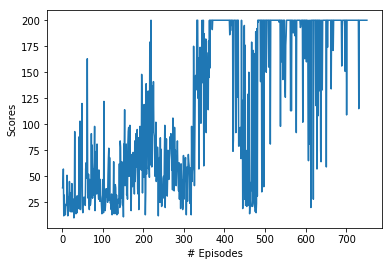

In [59]:
f = plt.figure()
ax = f.add_subplot(111)
plt.plot(range(1, len(scores) + 1), scores)
plt.xlabel('# Episodes')
plt.ylabel('Scores')
plt.show()

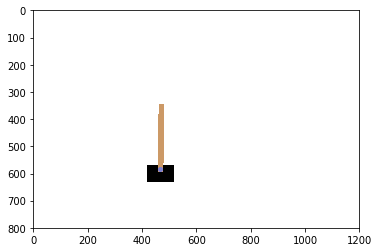

In [60]:
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))

while True:
    with torch.no_grad():
        action, _ = policy.act(state)
    
    state, reward, done, _ = env.step(action)
    img.set_data(env.render(mode='rgb_array'))
    if done:
        break

env.close()